In [37]:
import os
from pyannote.audio import Pipeline
import random
import wget
from pathlib import Path
from hashlib import md5
import gzip
import shutil
import tarfile
import pandas as pd
import torchaudio
import torch
from torchmetrics.text import WordErrorRate
from IPython.display import Audio
import torchaudio.functional as audio_func
from pyannote.core import notebook, Annotation, Segment, Timeline
from pyannote.metrics.segmentation import SegmentationCoverage, SegmentationPurity, SegmentationPrecision, SegmentationRecall
from pyannote.metrics.identification import IdentificationPrecision, IdentificationRecall, IdentificationErrorRate
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from nltk import word_tokenize
import string

In [2]:
random.seed(1337)

In [3]:
hf_token = os.environ["HUGGING_FACE_TOKEN"]

In [4]:
default_sample_rate = 16000

In [5]:
dataset_base_path = "cv-corpus-21.0-2025-03-14-ru/cv-corpus-21.0-2025-03-14/ru/"
clips_path = dataset_base_path + "clips/"
test_csv_path = dataset_base_path + "test.tsv"
invalidated_csv_path = dataset_base_path + "invalidated.tsv"

In [6]:
files = pd.read_csv(test_csv_path, sep="\t")
invalidated = pd.read_csv(invalidated_csv_path, sep="\t")
invalidated_ids = set(invalidated["client_id"])
files = files[~files["client_id"].isin(invalidated_ids)]

In [7]:
# About half an hour 
sample_count = 400
files = files.sample(sample_count)

In [8]:
def load_audio(file, target_sample_rate=default_sample_rate, **kwargs):
    tensor, sample_rate = torchaudio.load(file)
    tensor /= tensor.abs().max()
    return audio_func.resample(tensor, sample_rate, target_sample_rate) 

In [9]:
waveforms = [(row["sentence"], load_audio(clips_path + row["path"]), row["client_id"]) for idx, row in files.iterrows()]

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device("cpu")
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce GTX 1050 Ti is available.


In [11]:
vad = Pipeline.from_pretrained("pyannote/voice-activity-detection", use_auth_token=hf_token).to(device)
initial_params = {"onset": 0.4, "offset": 0.3, "min_duration_on": 0.0, "min_duration_off": 0.1}
vad.instantiate(initial_params);

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
/home/lemon/.local/lib/python3.13/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.6.0+cu124. Bad things might happen unless you revert torch to 1.x.


In [12]:
def has_repeating_speakers(ls):
    for i in range(len(ls) - 1):
        if ls[i][2] == ls[i + 1][2]:
            return True
    return False

In [13]:
while has_repeating_speakers(waveforms):
    random.shuffle(waveforms)

In [14]:
def measure_sample(tensor, sample_rate=default_sample_rate):
    activity = vad({"waveform": tensor, "sample_rate": sample_rate})
    if len(activity.get_timeline()) == 0:
        return None
    start = activity.get_timeline()[0].start
    end = activity.get_timeline()[-1].end
    return (start, end)

In [15]:
timed_waveforms = []
prev_end = 0

for ind, (stc, wf, client_id) in enumerate(waveforms):
    timings = measure_sample(wf.to(device))
    if timings is None:
        print(f"{ind} has no voice detected. Skipping")
        continue
    start, end = timings
    start += prev_end
    end += prev_end
    timed_waveforms += [(stc, wf, client_id, start, end)]
    prev_end += wf.size(1) / default_sample_rate

concat_waveform = torch.concat([wf for stc, wf, client_id, st, end in timed_waveforms], dim=1)

/home/lemon/.local/lib/python3.13/site-packages/pyannote/audio/utils/reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(


In [16]:
reference_annotation = Annotation()
for stc, wf, client_id, start, end in timed_waveforms:
    reference_annotation[Segment(start, end)] = client_id[:6]

In [ ]:
Audio(concat_waveform, rate=default_sample_rate)

In [18]:
segmentator = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=hf_token).to(device)

In [19]:
predicted_annotation = segmentator({"waveform": concat_waveform, "sample_rate": default_sample_rate})

/home/lemon/.local/lib/python3.13/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = sequences.std(dim=-1, correction=1)


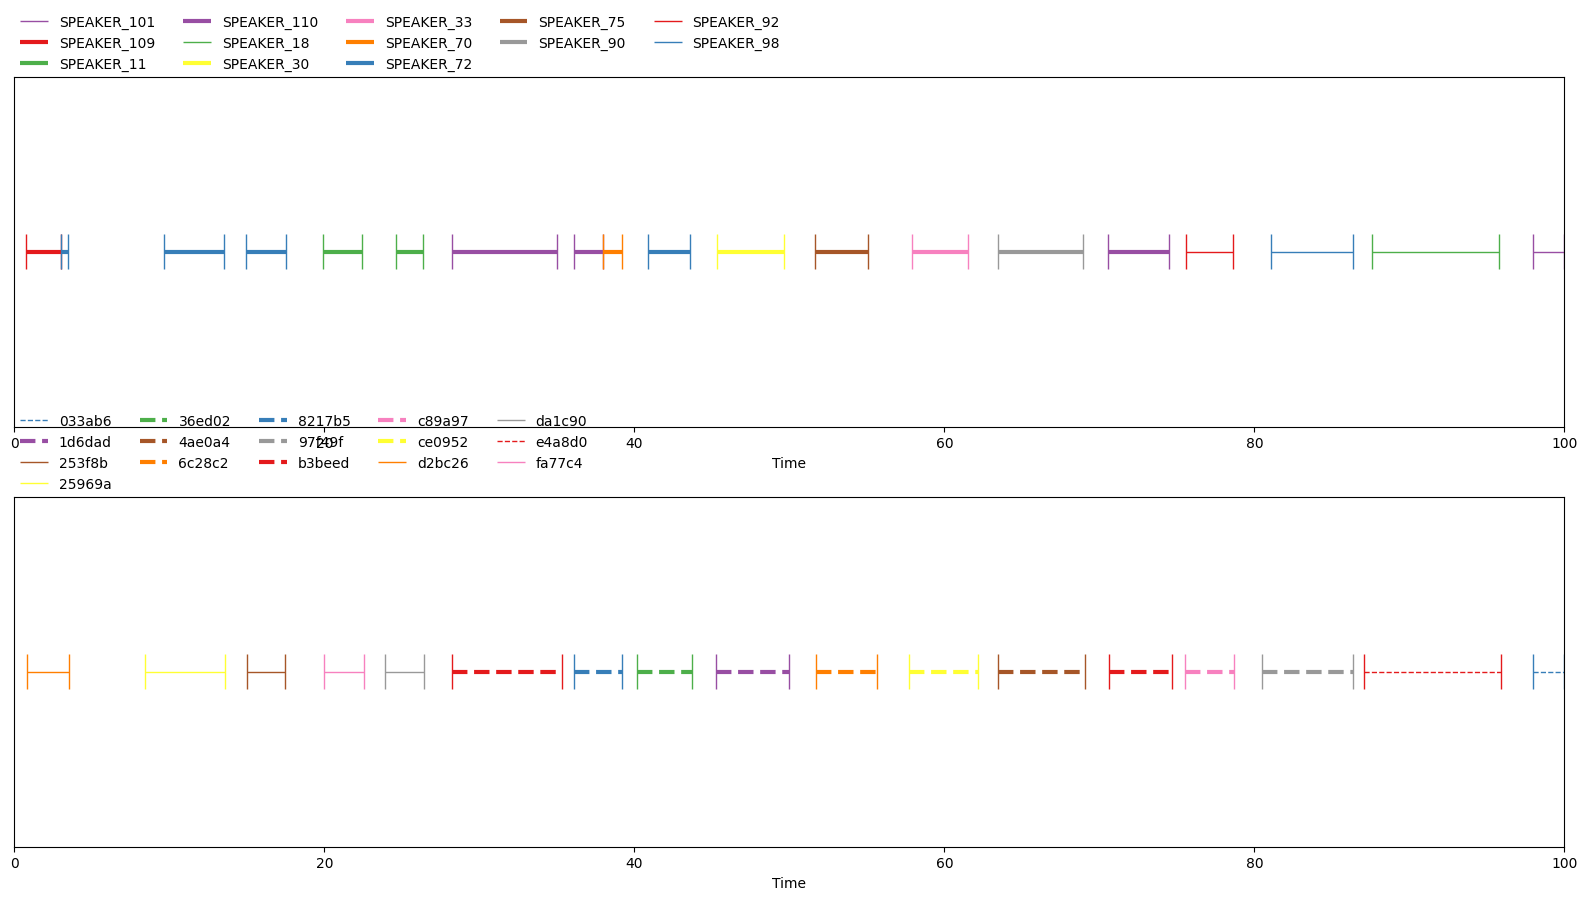

In [20]:
notebook.crop = Segment(0, 100)
figure, ax = plt.subplots(2, 1, figsize=(20, 10))
notebook.plot_annotation(predicted_annotation, ax=ax[0], time=True)
notebook.plot_annotation(reference_annotation, ax=ax[1], time=True)

In [21]:
SegmentationPrecision(tolerance=0.5)(reference_annotation, predicted_annotation)

0.7009708737864078

In [22]:
SegmentationRecall(tolerance=0.5)(reference_annotation, predicted_annotation)

0.9047619047619048

In [23]:
SegmentationCoverage()(reference_annotation, predicted_annotation)

0.8596911532835523

In [24]:
SegmentationPurity()(reference_annotation, predicted_annotation)

0.9998293045289861

In [25]:
IdentificationErrorRate()(reference_annotation, predicted_annotation)

/home/lemon/.local/lib/python3.13/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


1.0096912573874552

In [ ]:
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3-turbo"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

whisper = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

In [27]:
whisper({"raw": waveforms[0][1].numpy().reshape((-1,)), "sampling_rate": default_sample_rate, "language": "ru"})

/home/lemon/.local/lib/python3.13/site-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


{'text': ' Женщины эффективно принуждают к миру.', 'language': ['ru']}

In [28]:
start = 0
predicted_stc = []

for stc, wf, client_id, _, _ in tqdm(timed_waveforms):
    end = start + wf.size(1) / default_sample_rate
    segments = [s for s in predicted_annotation.itersegments() if s.end >= start and s.start <= end]
    snippet = torch.concat([concat_waveform.reshape((-1,))[int(s.start * default_sample_rate):int(s.end * default_sample_rate)] for s in segments])
    predicted_sentence = whisper({"raw": snippet.numpy(), "sampling_rate": default_sample_rate, "language": "ru"})["text"]
    predicted_stc += [predicted_sentence]
    print(stc, predicted_sentence)
    start = end

  0%|          | 0/400 [00:00<?, ?it/s]

Женщины эффективно принуждают к миру.  женщины эффективно принуждают к миру
Наша общая цель должна состоять в том, чтобы протокол стал универсальным.  Наша общая цель должна состоять в том, чтобы протокол стал универсальным.
Дело в том, что я точно люблю каракатицу.  Дело в том, что я точно люблю каракатицу.
В нём могут содержаться серьёзные ошибки!  В нем могут содержаться серьезные ошибки.
Так как же, Фома Фомич?  Так как же Фома Фомичи?
В настоящее время Камбоджа планирует увеличить число камбоджийских миротворцев, направляемых ею в другие страны.  В настоящее время Камбоджа планирует увеличить число камбоджийских миротворцев, направляемых ею в другие страны.
Тысячи людей сплошным потоком устремляются за пределы Сирии.  Тысячи людей с плашным потоком устремляются за пределы Сирии.
Особенно это актуально для района Сахеля.  Особенно это актуально для района Сахеля.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Ни слова о пледе. Если король узнает о его пропаже, нам — крышка!  Не сову о пледе. Если король узнает о его пропаже, нам крышка.
Благодарю представителя Аргентины за ее заявление.  Благодарю представителей Аргентины за ее заявление.
Она не судья, — оправляясь говорил Степан Аркадьич.  «Она не судья», — оправляясь, говорил Степан Аркадьевич.
Хотя еще далеко до завершения соглашения, начало переговорному процессу, безусловно, положено.  Хотя еще далеко до завершения соглашения, начало переговорному процессу безусловно положено.
В зале с интересом смотрели фильм Терминал с Томом Хенксом.  В зале с интересом смотрели фильм «Терминал» с Томом Хэнксом.
Но пустой голове всё трын трава.  Но в пустой голове все трынь трава.
Я надеюсь, что вы будете стремиться сформировать как можно более широкий консенсус.  И я надеюсь, что вы будете стремиться сформировать как можно более широкий консенсус.
Активизируются попытки подорвать конституционный порядок, установленный в результате свободного волеизъ

In [40]:
def tokenize(text):
    text = text.lower()
    tokens = word_tokenize(text, language="russian")
    tokens = [t for t in tokens if t not in string.punctuation]
    return tokens

In [41]:
predicted_tokenized = [" ".join(tokenize(s)) for s in predicted_stc]
reference_tokenized = [" ".join(tokenize(s)) for s, _, _, _, _ in timed_waveforms]

WordErrorRate()(predicted_tokenized, reference_tokenized).item()

0.08357857912778854